In [1]:
import re
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
import os
import seaborn as sns


/var/folders/cj/zz65s2xn0tg77qwwzwrzsylm0000gn/T/ipykernel_71888/1082578053.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
paths_metrics = glob(os.path.join('../inference-outputs','*','*.txt'))

In [3]:
paths_metrics[:3]

['../inference-outputs/hellaswag-en/hellaswag_meta-llama-Llama-3.3-70B-Instruct-Turbo_llm_judge_accuracy.txt',
 '../inference-outputs/hellaswag-en/hellaswag_Qwen-Qwen2.5-72B-Instruct-Turbo_accuracy.txt',
 '../inference-outputs/hellaswag-en/hellaswag_meta-llama-Meta-Llama-3.1-8B-Instruct-Turbo_rer.txt']

In [4]:
def get_score(path):
    with open(path, 'r') as f:
        data = f.readline()
    return float(data)
# --- Extract model size ---
def extract_size(model):
    match = re.search(r'(\d+)(B|M)', model.upper())
    if match:
        size = int(match.group(1))
        return size * (1_000 if match.group(2) == 'M' else 1_000_000)
    return None


In [5]:
category_map = {
    'hellaswag': 'commonsense',
    'winogrande': 'commonsense',
    'commonsenseqa': 'commonsense',
    'boolq': 'commonsense',
    'openbookqa': 'commonsense',
    'arc-easy': 'science',
    'arc-challenge': 'science',
    'gsm8k-main': 'math',
    'mmlu': 'multidomain',
}
model_map = {
    'deepseek-ai-DeepSeek-R1-Distill-Qwen-14B': 'deepseek-qwen-14B',
    'meta-llama-Llama-3.2-3B-Instruct-Turbo': 'llama-3.2-3B',
    'mistralai-Mistral-Small-24B-Instruct-2501': 'mistral-24B',
    'meta-llama-Meta-Llama-3.1-70B-Instruct-Turbo': 'llama-3.1-70B',
    'meta-llama-Meta-Llama-3.1-8B-Instruct-Turbo': 'llama-3.1-8B',
    'meta-llama-Llama-3.3-70B-Instruct-Turbo': 'llama-3.3-70B',
    'Qwen-Qwen2.5-72B-Instruct-Turbo': 'qwen2.5-72B',
    'Qwen-Qwen2.5-7B-Instruct-Turbo': 'qwen2.5-7B',
    'deepseek-ai-DeepSeek-R1-Distill-Llama-70B': 'deepseek-llama-70B',
    'mistralai-Mistral-7B-Instruct-v0.3': 'mistral-7B',
}

df = pd.DataFrame({'path': paths_metrics})
df['lang'] = df.path.apply(lambda x: x.split(os.sep)[-2].split('-')[-1])
df['dataset'] = df.path.apply(lambda x: x.split(os.sep)[-1].split('_')[0])
df['model'] = df.path.apply(lambda x: x.split(os.sep)[-1].split('_')[1])
df['model'] = df['model'].map(model_map)
df['model_family'] = df.path.apply(lambda x: x.split(os.sep)[-1].split('_')[1].split('-')[0])
df['metric_type'] = df.path.apply(lambda x: x.split(os.sep)[-1].split('_')[2].split('.')[0])
df['score'] = df.path.apply(lambda x: get_score(x))
df['model_size'] = df['model'].apply(extract_size)
df['dataset_category'] = df['dataset'].map(category_map)
# --- Convert RER to RAR (Response Adherence Rate) ---
# RAR = 1 - RER, and replace in 'score' if metric_type == 'rer'
df.loc[df['metric_type'] == 'rer', 'score'] = 1 - df.loc[df['metric_type'] == 'rer', 'score']
df.loc[df['metric_type'] == 'rer', 'metric_type'] = 'rar'

# --- Rename 'llm' to 'llm-judge' in metric_type ---
df.loc[df['metric_type'] == 'llm', 'metric_type'] = 'llm-judge'

In [6]:
df

,path,lang,dataset,model,model_family,metric_type,score,model_size,dataset_category
0,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.3-70B,meta,llm-judge,0.416550,70000000,commonsense
1,../inference-outputs/hellaswag-en/hellaswag_Qw...,en,hellaswag,qwen2.5-72B,Qwen,accuracy,0.905099,72000000,commonsense
2,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.1-8B,meta,rar,1.000000,8000000,commonsense
3,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.2-3B,meta,rar,0.999602,3000000,commonsense
4,../inference-outputs/hellaswag-en/hellaswag_de...,en,hellaswag,deepseek-llama-70B,deepseek,llm-judge,0.933479,70000000,commonsense
...,...,...,...,...,...,...,...,...,...
535,../inference-outputs/mmlu-bn/mmlu_deepseek-ai-...,bn,mmlu,deepseek-llama-70B,deepseek,accuracy,0.552383,70000000,multidomain
536,../inference-outputs/mmlu-bn/mmlu_meta-llama-M...,bn,mmlu,llama-3.1-8B,meta,rar,0.743024,8000000,multidomain
537,../inference-outputs/mmlu-bn/mmlu_mistralai-Mi...,bn,mmlu,mistral-7B,mistralai,llm-judge,0.282356,7000000,multidomain
538,../inference-outputs/mmlu-bn/mmlu_meta-llama-L...,bn,mmlu,llama-3.2-3B,meta,rar,0.968419,3000000,multidomain


In [7]:
import pandas as pd

# load combined csv
token_df_row = pd.read_csv("../tokenization-results/count-per-row/combined_average_tokens_per_row.csv")

# rename columns
token_df_row = token_df_row.rename(columns={
    "Model":                             "model",
    "Dataset":                           "dataset",
    "Language":                          "lang",  
    "Average Token Count Per Row":      "average_token_count_per_row",
    "Average Bytes Per Token":          "average_bytes_per_token",
    "Average Normalized Sequence Length":"average_normalized_seq_len"
})

# merge on 3 keys
df = df.merge(
    token_df_row[
        [
            "model",
            "dataset",
            "lang",
            "average_token_count_per_row",
            "average_bytes_per_token",
            "average_normalized_seq_len"
        ]
    ],
    on=["model", "dataset", "lang"],
    how="left"
)

df.head()


,path,lang,dataset,model,model_family,metric_type,score,model_size,dataset_category,average_token_count_per_row,average_bytes_per_token,average_normalized_seq_len
0,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.3-70B,meta,llm-judge,0.416550,70000000,commonsense,255.654504,4.589883,1.000000
1,../inference-outputs/hellaswag-en/hellaswag_Qw...,en,hellaswag,qwen2.5-72B,Qwen,accuracy,0.905099,72000000,commonsense,255.224733,4.601700,0.997549
2,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.1-8B,meta,rar,1.000000,8000000,commonsense,255.654504,4.589883,1.000000
3,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.2-3B,meta,rar,0.999602,3000000,commonsense,255.654504,4.589883,1.000000
4,../inference-outputs/hellaswag-en/hellaswag_de...,en,hellaswag,deepseek-llama-70B,deepseek,llm-judge,0.933479,70000000,commonsense,255.654504,4.589883,1.000000


In [8]:
import pandas as pd

# load combined csv
token_df_word = pd.read_csv(
    "../tokenization-results/count-per-word/combined_average_tokens_per_word.csv"
)

# correct the rename mapping:
token_df_word = token_df_word.rename(columns={
    "Model":                            "model",
    "Dataset":                          "dataset",
    "Language":                         "lang",
    "Average Token Count Per Word":     "average_token_count_per_word"
})

# now merge on the three keys
df = df.merge(
    token_df_word[
        ["model", "dataset", "lang", "average_token_count_per_word"]
    ],
    on=["model", "dataset", "lang"],
    how="left"
)

df.head()


,path,lang,dataset,model,model_family,metric_type,score,model_size,dataset_category,average_token_count_per_row,average_bytes_per_token,average_normalized_seq_len,average_token_count_per_word
0,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.3-70B,meta,llm-judge,0.416550,70000000,commonsense,255.654504,4.589883,1.000000,1.263424
1,../inference-outputs/hellaswag-en/hellaswag_Qw...,en,hellaswag,qwen2.5-72B,Qwen,accuracy,0.905099,72000000,commonsense,255.224733,4.601700,0.997549,1.260438
2,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.1-8B,meta,rar,1.000000,8000000,commonsense,255.654504,4.589883,1.000000,1.263424
3,../inference-outputs/hellaswag-en/hellaswag_me...,en,hellaswag,llama-3.2-3B,meta,rar,0.999602,3000000,commonsense,255.654504,4.589883,1.000000,1.263424
4,../inference-outputs/hellaswag-en/hellaswag_de...,en,hellaswag,deepseek-llama-70B,deepseek,llm-judge,0.933479,70000000,commonsense,255.654504,4.589883,1.000000,1.263424


In [9]:
df.columns

Index(['path', 'lang', 'dataset', 'model', 'model_family', 'metric_type',
       'score', 'model_size', 'dataset_category',
       'average_token_count_per_row', 'average_bytes_per_token',
       'average_normalized_seq_len', 'average_token_count_per_word'],
      dtype='object')

In [10]:
df[['lang', 'dataset', 'model', 'model_family','model_size', 'metric_type']].nunique()

lang             2
dataset          9
model           10
model_family     4
model_size       7
metric_type      3
dtype: int64

In [11]:
for col in ['lang', 'dataset', 'model', 'model_family','model_size', 'metric_type']:
    print(col)
    print(df[col].unique())

lang
['en' 'bn']
dataset
['hellaswag' 'arc-challenge' 'openbookqa' 'arc-easy' 'boolq' 'gsm8k-main'
 'commonsenseqa' 'mmlu' 'winogrande']
model
['llama-3.3-70B' 'qwen2.5-72B' 'llama-3.1-8B' 'llama-3.2-3B'
 'deepseek-llama-70B' 'deepseek-qwen-14B' 'mistral-24B' 'llama-3.1-70B'
 'mistral-7B' 'qwen2.5-7B']
model_family
['meta' 'Qwen' 'deepseek' 'mistralai']
model_size
[70000000 72000000  8000000  3000000 14000000 24000000  7000000]
metric_type
['llm-judge' 'accuracy' 'rar']


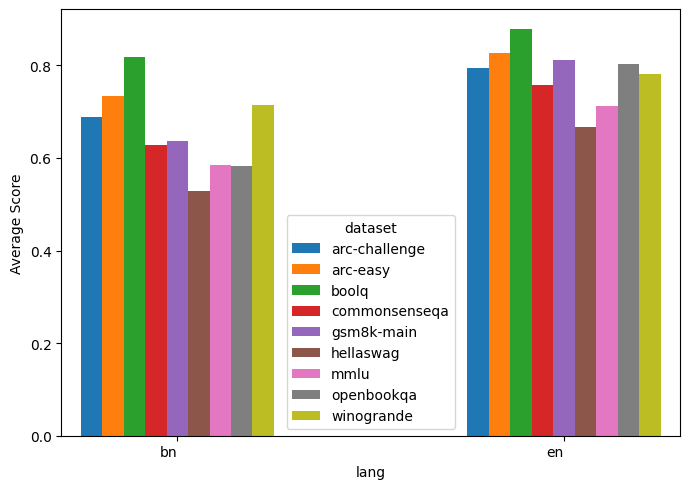

In [12]:
# Visualization
summary_stats_plot = df.groupby(['lang', 'dataset'])['score'].mean().unstack()
fig, ax = plt.subplots(figsize=(7, 5))
summary_stats_plot.plot(kind='bar', rot= 0, ax=ax, width=0.5)  # Reduce bar width

ax.set_ylabel('Average Score')
# ax.set_title('Average Score by Dataset and Language')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')

# Reduce white space
ax.set_xlim(-0.3, len(summary_stats_plot.index) - 0.7)

plt.tight_layout()
plt.savefig('../fig/score_by_dataset_lang.png', dpi=150)
plt.show()


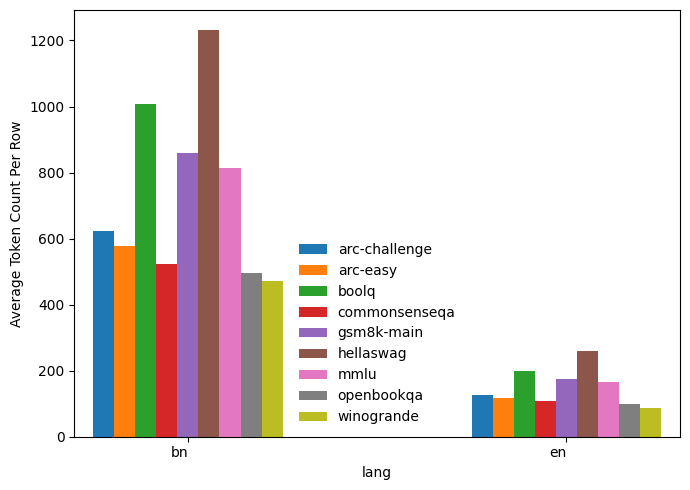

In [ ]:
# Visualization for Tokenization
summary_stats_plot = df.groupby(['lang', 'dataset'])['average_normalized_seq_len'].mean().unstack()
fig, ax = plt.subplots(figsize=(7, 5))
summary_stats_plot.plot(kind='bar', rot= 0, ax=ax, width=0.5)

ax.set_ylabel('Average Token Count Per Row')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.legend(
    loc='lower center',
    frameon=False
)

# Reduce white space
ax.set_xlim(-0.3, len(summary_stats_plot.index) - 0.7)

plt.tight_layout()
plt.savefig('../fig/average_normalized_seq_len.png', dpi=150)
plt.show()

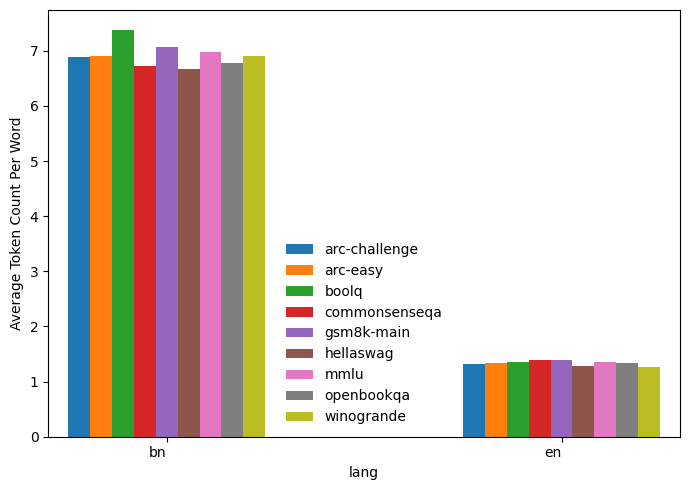

In [14]:
# Visualization for Tokenization
summary_stats_plot = df.groupby(['lang', 'dataset'])['average_token_count_per_word'].mean().unstack()
fig, ax = plt.subplots(figsize=(7, 5))
summary_stats_plot.plot(kind='bar', rot= 0, ax=ax, width=0.5)

ax.set_ylabel('Average Token Count Per Word')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.legend(
    loc='lower center',
    frameon=False
)

# Reduce white space
ax.set_xlim(-0.3, len(summary_stats_plot.index) - 0.7)

plt.tight_layout()
plt.savefig('../fig/average_token_count_per_word.png', dpi=150)
plt.show()

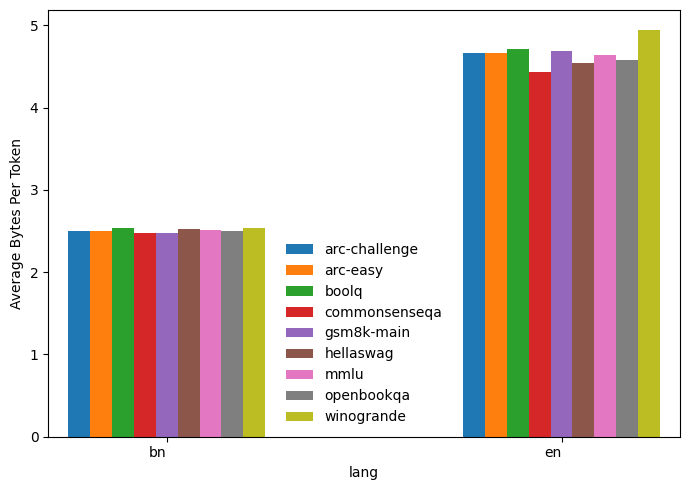

In [15]:
# Visualization for Tokenization
summary_stats_plot = df.groupby(['lang', 'dataset'])['average_bytes_per_token'].mean().unstack()
fig, ax = plt.subplots(figsize=(7, 5))
summary_stats_plot.plot(kind='bar', rot= 0, ax=ax, width=0.5)

ax.set_ylabel('Average Bytes Per Token')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.legend(
    loc='lower center',
    frameon=False
)

# Reduce white space
ax.set_xlim(-0.3, len(summary_stats_plot.index) - 0.7)

plt.tight_layout()
plt.savefig('../fig/average_bytes_per_token.png', dpi=150)
plt.show()

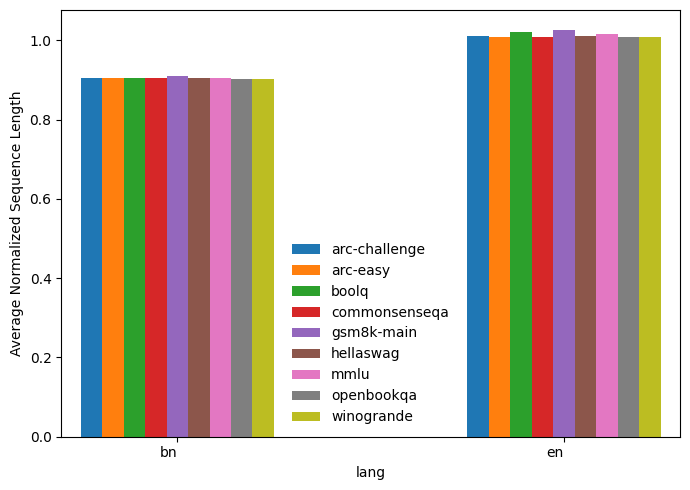

In [16]:
# Visualization for Tokenization
summary_stats_plot = df.groupby(['lang', 'dataset'])['average_normalized_seq_len'].mean().unstack()
fig, ax = plt.subplots(figsize=(7, 5))
summary_stats_plot.plot(kind='bar', rot= 0, ax=ax, width=0.5)

ax.set_ylabel('Average Normalized Sequence Length')
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.legend(
    loc='lower center',
    frameon=False
)

# Reduce white space
ax.set_xlim(-0.3, len(summary_stats_plot.index) - 0.7)

plt.tight_layout()
plt.savefig('../fig/average_normalized_seq_len.png', dpi=150)
plt.show()

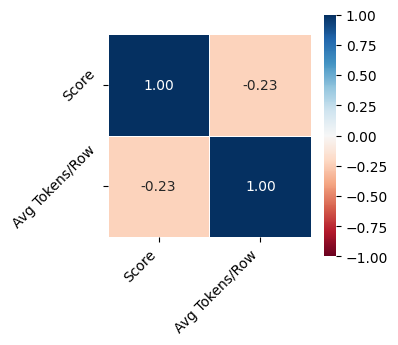

In [17]:
corr_row = df[['score', 'average_token_count_per_row']].corr()

labels = ['Score', 'Avg Tokens/Row']

plt.figure(figsize=(4, 4))
sns.heatmap(
    corr_row,
    annot=True,
    fmt=".2f",
    cmap='RdBu',
    vmin=-1, vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'shrink': 0.8},
    square=True, 
    linewidths=0.5
)

# 3) Rotate/align the ticks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.tight_layout()
plt.savefig('../fig/score_vs_avg_token_count_per_row_corr_heatmap.png', dpi=150)
plt.show()


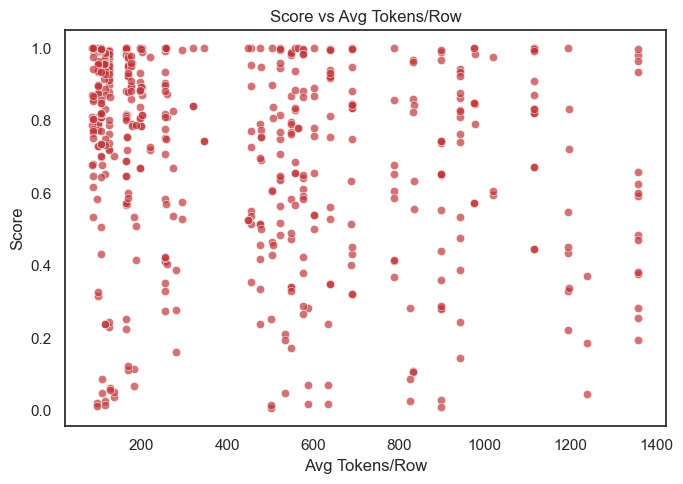

In [18]:
sns.set_theme(style="white")
sns.set_palette("RdBu")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="average_token_count_per_row",
    y="score",
    data=df,
    alpha=0.7,
    edgecolor="w",
    linewidth=0.5
)


plt.xlabel("Avg Tokens/Row")
plt.ylabel("Score")
plt.title("Score vs Avg Tokens/Row")

plt.tight_layout()
plt.savefig('../fig/score_vs_avg_token_count_per_row_scatter.png', dpi=150)
plt.show()


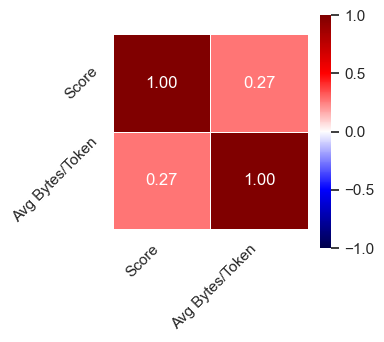

In [23]:
corr_word = df[['score', 'average_bytes_per_token']].corr()

labels = ['Score', 'Avg Bytes/Token']

plt.figure(figsize=(4, 4))
sns.heatmap(
    corr_word,
    annot=True,
    fmt=".2f",
    cmap='seismic',
    vmin=-1, vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'shrink': 0.8},
    square=True, 
    linewidths=0.5
)

# 3) Rotate/align the ticks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.tight_layout()
plt.savefig('../fig/score_vs_average_bytes_per_token_heatmap.png', dpi=150)
plt.show()


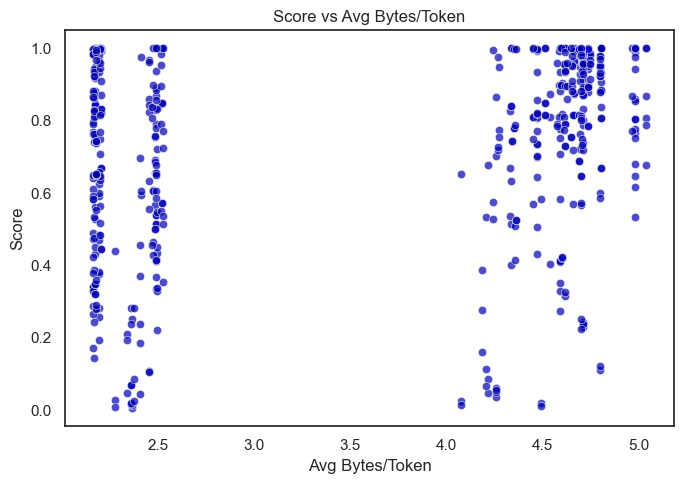

In [24]:
sns.set_theme(style="white")
sns.set_palette("seismic")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="average_bytes_per_token",
    y="score",
    data=df,
    alpha=0.7,
    edgecolor="w",
    linewidth=0.5
)


plt.xlabel("Avg Bytes/Token")
plt.ylabel("Score")
plt.title("Score vs Avg Bytes/Token")

plt.tight_layout()
plt.savefig('../fig/score_vs_average_bytes_per_token_scatter.png', dpi=150)
plt.show()


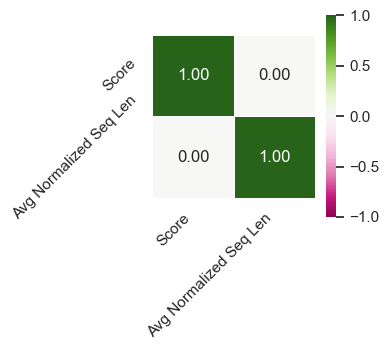

In [29]:
corr_word = df[['score', 'average_normalized_seq_len']].corr()

labels = ['Score', 'Avg Normalized Seq Len']

plt.figure(figsize=(4, 4))
sns.heatmap(
    corr_word,
    annot=True,
    fmt=".2f",
    cmap='PiYG',
    vmin=-1, vmax=1,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'shrink': 0.8},
    square=True, 
    linewidths=0.5
)

# 3) Rotate/align the ticks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.tight_layout()
plt.savefig('../fig/score_vs_average_normalized_seq_len_heatmap.png', dpi=150)
plt.show()


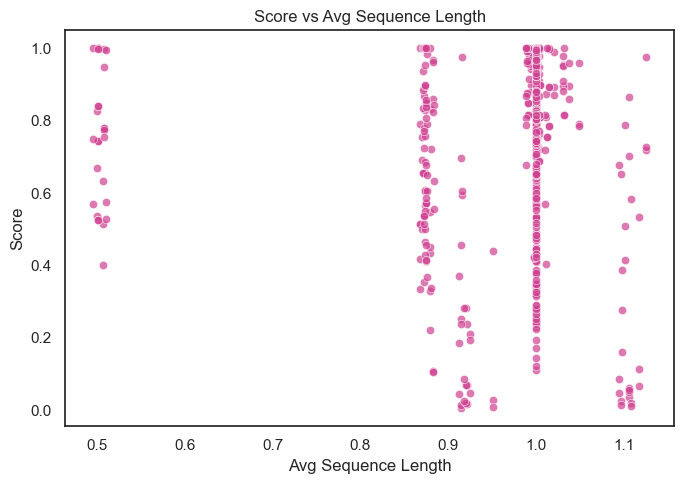

In [30]:
sns.set_theme(style="white")
sns.set_palette("PiYG")

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x="average_normalized_seq_len",
    y="score",
    data=df,
    alpha=0.7,
    edgecolor="w",
    linewidth=0.5
)


plt.xlabel("Avg Sequence Length")
plt.ylabel("Score")
plt.title("Score vs Avg Sequence Length")

plt.tight_layout()
plt.savefig('../fig/score_vs_average_normalized_seq_len_scatter.png', dpi=150)
plt.show()



Performance by Model Size:
metric_type lang  model_size  accuracy  llm-judge       rar
0             bn     3000000  0.322373   0.353319  0.935922
1             bn     7000000  0.290332   0.409253  0.637443
2             bn     8000000  0.401006   0.495713  0.809752
3             bn    14000000  0.514686   0.766823  0.787990
4             bn    24000000  0.636822   0.681094  0.934067
5             bn    70000000  0.713660   0.790427  0.925051
6             bn    72000000  0.599494   0.767446  0.753440
7             en     3000000  0.658100   0.657282  0.982785
8             en     7000000  0.493065   0.709763  0.628595
9             en     8000000  0.681971   0.668785  0.980258
10            en    14000000  0.750328   0.908223  0.859633
11            en    24000000  0.833004   0.805966  0.974978
12            en    70000000  0.731246   0.874499  0.817263
13            en    72000000  0.894956   0.856367  0.990973


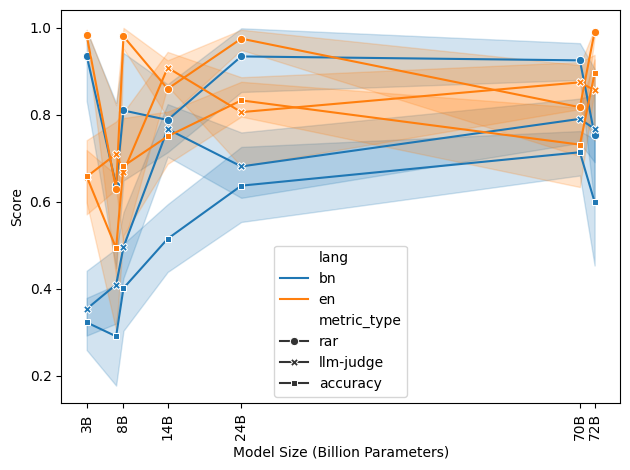

In [ ]:
# --- 2. Performance by Model Size ---
size_perf = df.groupby(['lang', 'model_size', 'metric_type'])['score'].mean().unstack().reset_index()
print("\nPerformance by Model Size:")
print(size_perf)

# Visualization
sns.lineplot(data=df, x='model_size', y='score', hue='lang', style='metric_type', markers=True, dashes=False)
plt.xlabel('Model Size (Billion Parameters)')
plt.ylabel('Score')

# Format x-axis ticks to show billions as '7B', '70B', etc.
xticks = sorted(df['model_size'].dropna().unique())
xticks.pop(1)
xticklabels = [f"{int(x / 1e6)}B" for x in xticks]

plt.xticks(xticks, xticklabels, rotation=90, fontsize=10)
plt.subplots_adjust(bottom=0.25)

plt.tight_layout()
plt.savefig('../fig/model_size_vs_score_by_lang_metric_type.png', dpi=150)
plt.show()


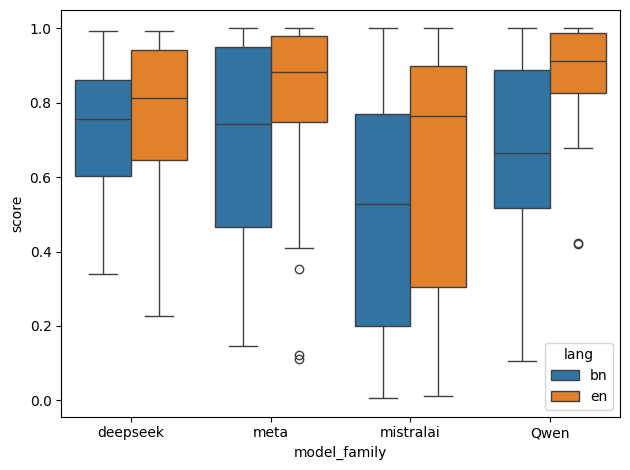

In [ ]:

# --- 3. Model Family Performance Across Languages ---
sns.boxplot(data=df, x='model_family', y='score', hue='lang')
# plt.title('Model Family Performance across Languages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../fig/scores_across_model_family.png', dpi = 150)
plt.show()


In [55]:

# --- 4. Rank Models per Dataset and Language ---
df['rank'] = df.groupby(['lang', 'dataset', 'metric_type'])['score'].rank(ascending=False, method='min')
top_models = df[df['rank'] <= 3].sort_values(by=['lang', 'dataset', 'rank'])
print("\nTop 3 Models per Dataset and Language:")
print(top_models[['lang', 'dataset', 'model', 'score', 'rank']])


Top 3 Models per Dataset and Language:
    lang        dataset               model     score  rank
273   bn  arc-challenge  deepseek-llama-70B  0.883106   1.0
274   bn  arc-challenge        llama-3.2-3B  1.000000   1.0
287   bn  arc-challenge       llama-3.1-70B  0.845563   1.0
288   bn  arc-challenge         mistral-24B  1.000000   1.0
296   bn  arc-challenge          qwen2.5-7B  1.000000   1.0
..   ...            ...                 ...       ...   ...
449   en     winogrande          qwen2.5-7B  1.000000   1.0
431   en     winogrande       llama-3.1-70B  0.805051   2.0
442   en     winogrande   deepseek-qwen-14B  0.975533   2.0
423   en     winogrande       llama-3.3-70B  0.804262   3.0
435   en     winogrande         qwen2.5-72B  0.869771   3.0

[169 rows x 5 columns]


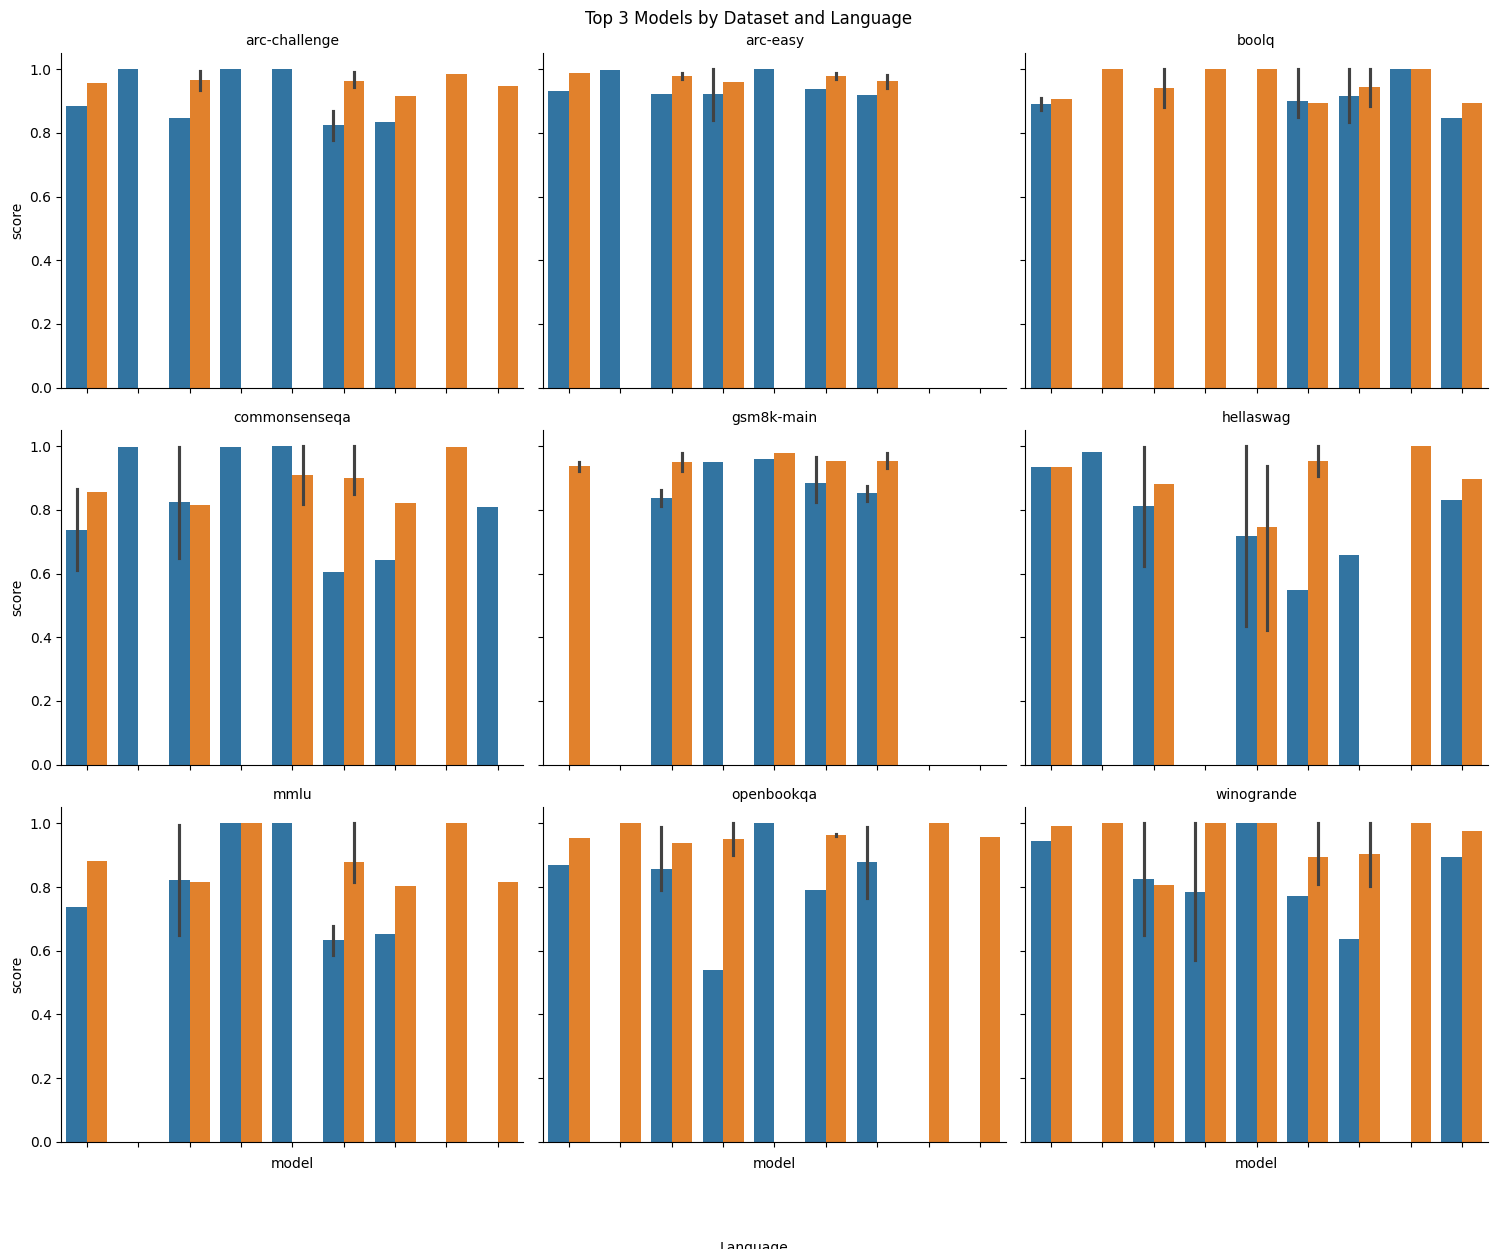

In [44]:
# Visualization with legend adjustment
g = sns.catplot(
    data=top_models, 
    x='model', y='score', hue='lang', 
    col='dataset', kind='bar', 
    height=4, aspect=1.2, col_wrap=3
)

g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45)

# Move legend to bottom center
g._legend.set_bbox_to_anchor((0.5, -0.05))
g._legend.set_loc('lower center')
g._legend.set_title('Language')  # Optional: rename legend title

# Adjust layout
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Top 3 Models by Dataset and Language')
plt.tight_layout()
plt.show()



Performance Gap (English - Bangla):
lang               model        dataset metric_type  score_gap
256           qwen2.5-7B     gsm8k-main   llm-judge   0.786202
255           qwen2.5-7B     gsm8k-main    accuracy   0.776346
231          qwen2.5-72B      hellaswag    accuracy   0.683529
233          qwen2.5-72B      hellaswag         rar   0.669886
104         llama-3.1-8B     openbookqa         rar   0.658000
..                   ...            ...         ...        ...
20    deepseek-llama-70B           mmlu         rar  -0.491312
3     deepseek-llama-70B       arc-easy    accuracy  -0.516835
0     deepseek-llama-70B  arc-challenge    accuracy  -0.517918
5     deepseek-llama-70B       arc-easy         rar  -0.574916
2     deepseek-llama-70B  arc-challenge         rar  -0.600683

[270 rows x 4 columns]


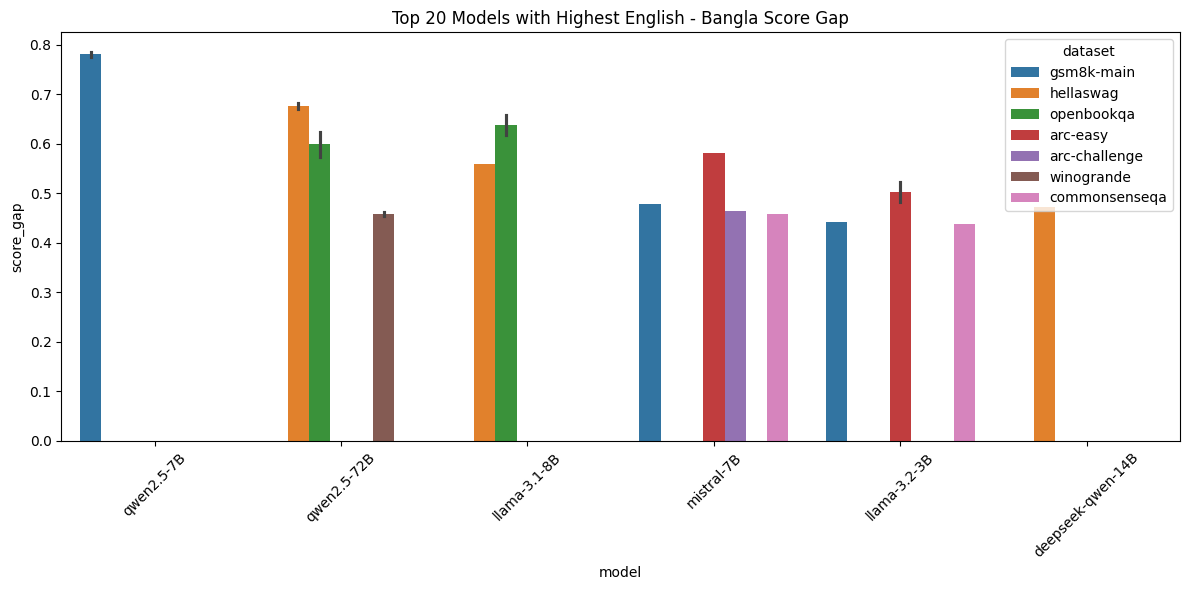

In [45]:

# --- 5. Cross-Language Performance Gap ---
pivot = df.pivot_table(index=['model', 'model_family', 'model_size', 'dataset', 'metric_type'],
                       columns='lang', values='score').reset_index()

if 'en' in pivot.columns and 'bn' in pivot.columns:
    pivot['score_gap'] = pivot['en'] - pivot['bn']
    print("\nPerformance Gap (English - Bangla):")
    print(pivot[['model', 'dataset', 'metric_type', 'score_gap']].sort_values(by='score_gap', ascending=False))

    # Visualization
    gap_sorted = pivot.sort_values(by='score_gap', ascending=False).head(20)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=gap_sorted, x='model', y='score_gap', hue='dataset')
    plt.title('Top 20 Models with Highest English - Bangla Score Gap')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [34]:
# Step 1: Average score across metric types per model, dataset, and language
avg_df = df.groupby(['model', 'model_family', 'model_size', 'dataset', 'lang'])['score'].mean().reset_index()

# Step 2: Pivot so each row is a model-dataset, with separate columns for en and bn
pivot_avg = avg_df.pivot_table(index=['model', 'model_family', 'model_size', 'dataset'],
                                columns='lang', values='score').reset_index()
pivot_avg

lang,model,model_family,model_size,dataset,bn,en
0,Qwen-Qwen2.5-72B-Instruct-Turbo,Qwen,72000000,arc-challenge,0.845563,0.961604
1,Qwen-Qwen2.5-72B-Instruct-Turbo,Qwen,72000000,arc-easy,0.885802,0.979377
2,Qwen-Qwen2.5-72B-Instruct-Turbo,Qwen,72000000,boolq,0.898879,0.928644
3,Qwen-Qwen2.5-72B-Instruct-Turbo,Qwen,72000000,commonsenseqa,0.704614,0.899536
4,Qwen-Qwen2.5-72B-Instruct-Turbo,Qwen,72000000,gsm8k-main,0.883750,0.938843
...,...,...,...,...,...,...
85,mistralai-Mistral-Small-24B-Instruct-2501,mistralai,24000000,gsm8k-main,0.826131,0.845843
86,mistralai-Mistral-Small-24B-Instruct-2501,mistralai,24000000,hellaswag,0.515900,0.696176
87,mistralai-Mistral-Small-24B-Instruct-2501,mistralai,24000000,mmlu,0.684452,0.836037
88,mistralai-Mistral-Small-24B-Instruct-2501,mistralai,24000000,openbookqa,0.678667,0.933333



Average Metric Gap (English - Bangla):
lang               model        dataset  score_gap
34          llama-3.1-8B     openbookqa   0.530667
85            qwen2.5-7B     gsm8k-main   0.526914
79           qwen2.5-72B     openbookqa   0.458000
67            mistral-7B     gsm8k-main   0.411423
77           qwen2.5-72B      hellaswag   0.408916
..                   ...            ...        ...
3     deepseek-llama-70B  commonsenseqa  -0.187551
6     deepseek-llama-70B           mmlu  -0.224289
71            mistral-7B     winogrande  -0.259142
1     deepseek-llama-70B       arc-easy  -0.345819
0     deepseek-llama-70B  arc-challenge  -0.348123

[90 rows x 3 columns]


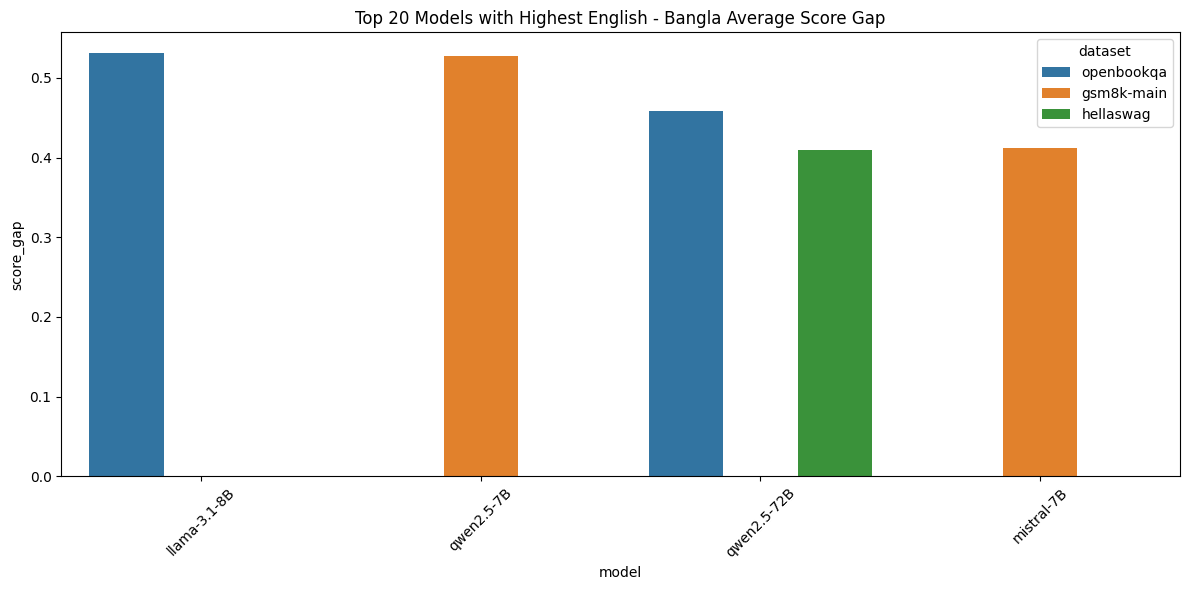

In [46]:
# Step 1: Average score across metric types per model, dataset, and language
avg_df = df.groupby(['model', 'model_family', 'model_size', 'dataset', 'lang'])['score'].mean().reset_index()

# Step 2: Pivot so each row is a model-dataset, with separate columns for en and bn
pivot_avg = avg_df.pivot_table(index=['model', 'model_family', 'model_size', 'dataset'],
                                columns='lang', values='score').reset_index()

# Step 3: Compute the gap (English - Bangla)
pivot_avg['score_gap'] = pivot_avg['en'] - pivot_avg['bn']
print("\nAverage Metric Gap (English - Bangla):")
print(pivot_avg[['model', 'dataset', 'score_gap']].sort_values(by='score_gap', ascending=False))

# Step 4: Plot top 20 models with highest cross-language gap
gap_sorted = pivot_avg.sort_values(by='score_gap', ascending=False).head(5)
plt.figure(figsize=(12, 6))
sns.barplot(data=gap_sorted, x='model', y='score_gap', hue='dataset')
plt.title('Top 20 Models with Highest English - Bangla Average Score Gap')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


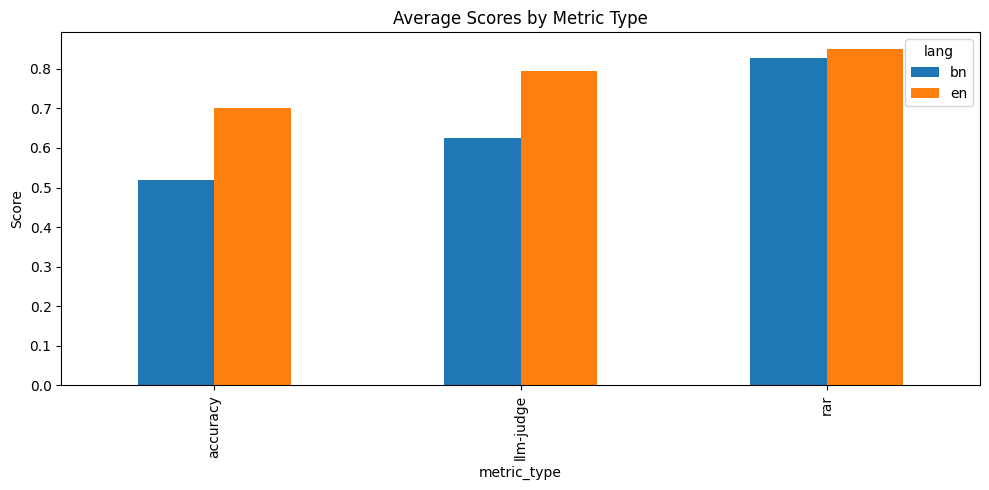

In [28]:

# --- 6. Metric-Type Specific Trends ---
metric_summary = df.groupby(['metric_type', 'lang'])['score'].mean().unstack()
metric_summary.plot(kind='bar', title='Average Scores by Metric Type', figsize=(10, 5))
plt.ylabel('Score')
plt.tight_layout()
plt.show()



Most Robust Model Families (Lowest Std Dev across Languages):
model_family  metric_type
mistralai     rar            0.010142
deepseek      accuracy       0.019887
meta          rar            0.033220
deepseek      llm-judge      0.070152
              rar            0.078585
Qwen          rar            0.082046
mistralai     accuracy       0.089833
meta          llm-judge      0.118835
Qwen          llm-judge      0.138407
mistralai     llm-judge      0.149673
meta          accuracy       0.150055
Qwen          accuracy       0.227343
dtype: float64


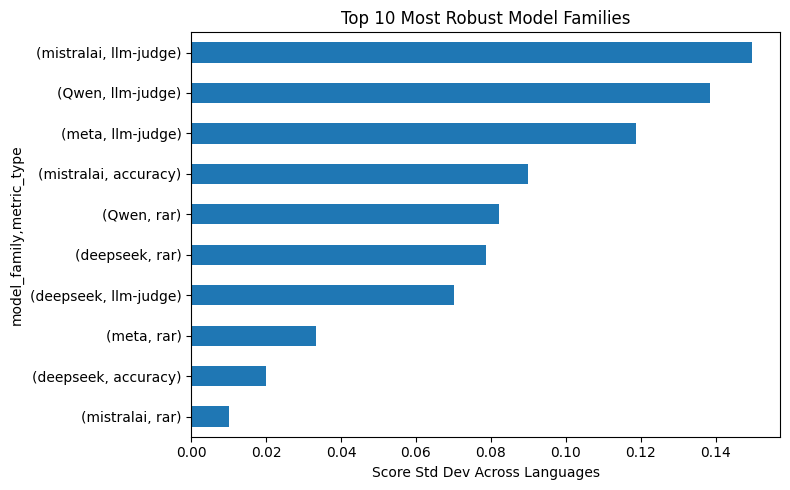

In [47]:

# --- 7. Language Robustness of Model Families ---
lang_variability = df.groupby(['model_family', 'metric_type', 'lang'])['score'].mean().unstack().std(axis=1)
robust_models = lang_variability.sort_values(ascending=True)
print("\nMost Robust Model Families (Lowest Std Dev across Languages):")
print(robust_models)

# Visualization
robust_models.head(10).plot(kind='barh', figsize=(8, 5), title='Top 10 Most Robust Model Families')
plt.xlabel('Score Std Dev Across Languages')
plt.tight_layout()
plt.show()



Most Robust Model Families (Lowest Std Dev across Languages):
model_family
deepseek     0.003818
mistralai    0.083216
meta         0.100703
Qwen         0.149265
dtype: float64


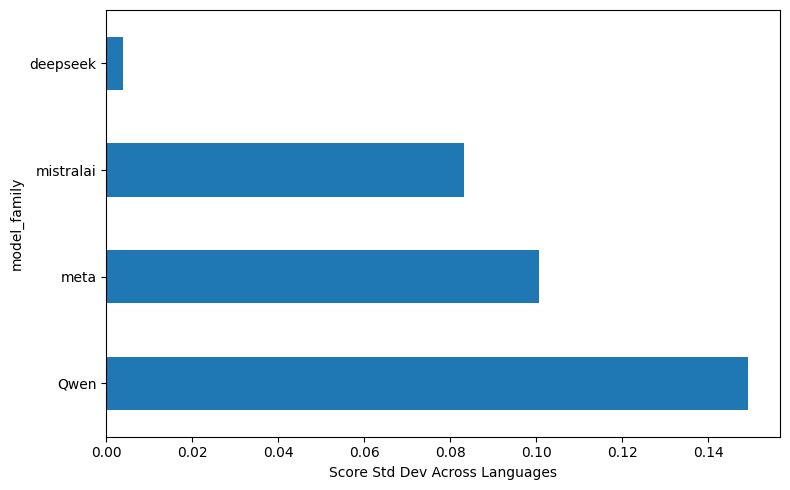

In [ ]:
# --- 7. Language Robustness of Model Families ---

# Step 1: Average scores per model_family and lang across all datasets and metric types
avg_scores = df.groupby(['model_family', 'lang'])['score'].mean().unstack()

# Step 2: Compute standard deviation across languages
lang_variability = avg_scores.std(axis=1)

# Step 3: Sort models by robustness (lower std = more robust)
robust_models = lang_variability.sort_values(ascending=True)

# Step 4: Display results
print("\nMost Robust Model Families (Lowest Std Dev across Languages):")
print(robust_models)

# Visualization (reversed to show lowest std dev at top)
robust_models.head(10).iloc[::-1].plot(
    kind='barh', figsize=(8, 5), 
    # title='Top 10 Most Robust Model Families'
)
plt.xlabel('Score Std Dev Across Languages')
plt.tight_layout()
plt.savefig('../fig/score_std_dev_across_lang.png', dpi = 150)
plt.show()


/tmp/ipykernel_876337/2392609615.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


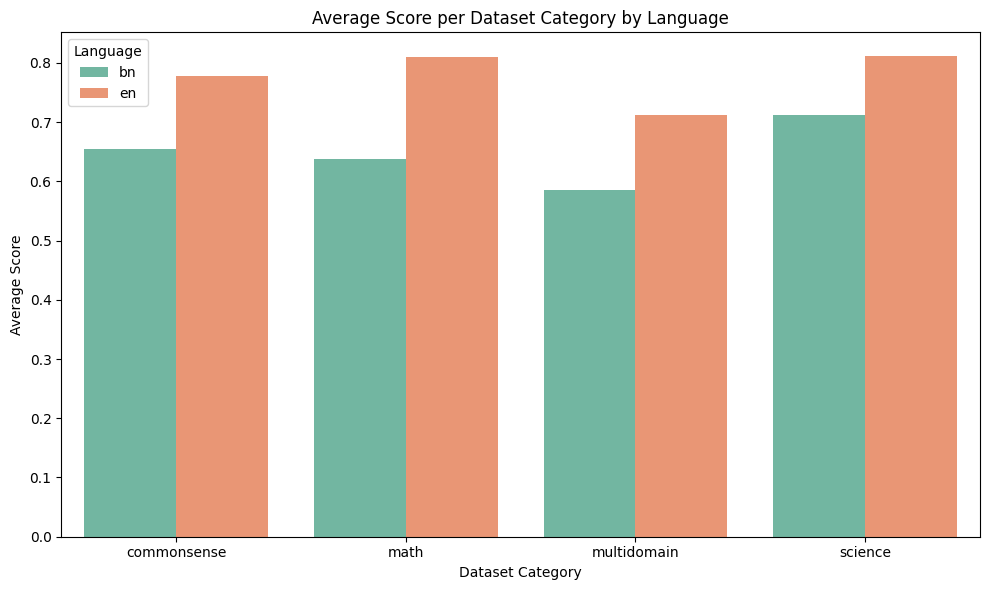

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group scores by category, language, and metric type
category_scores = df.groupby(['dataset_category', 'lang', 'metric_type'])['score'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_scores,
    x='dataset_category', y='score',
    hue='lang', ci=None,
    palette='Set2'
)
plt.title('Average Score per Dataset Category by Language')
plt.ylabel('Average Score')
plt.xlabel('Dataset Category')
plt.legend(title='Language')
plt.tight_layout()
plt.savefig('../fig/avg_score_by_category_lang.png', dpi=150)
plt.show()


/tmp/ipykernel_876337/1587311101.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


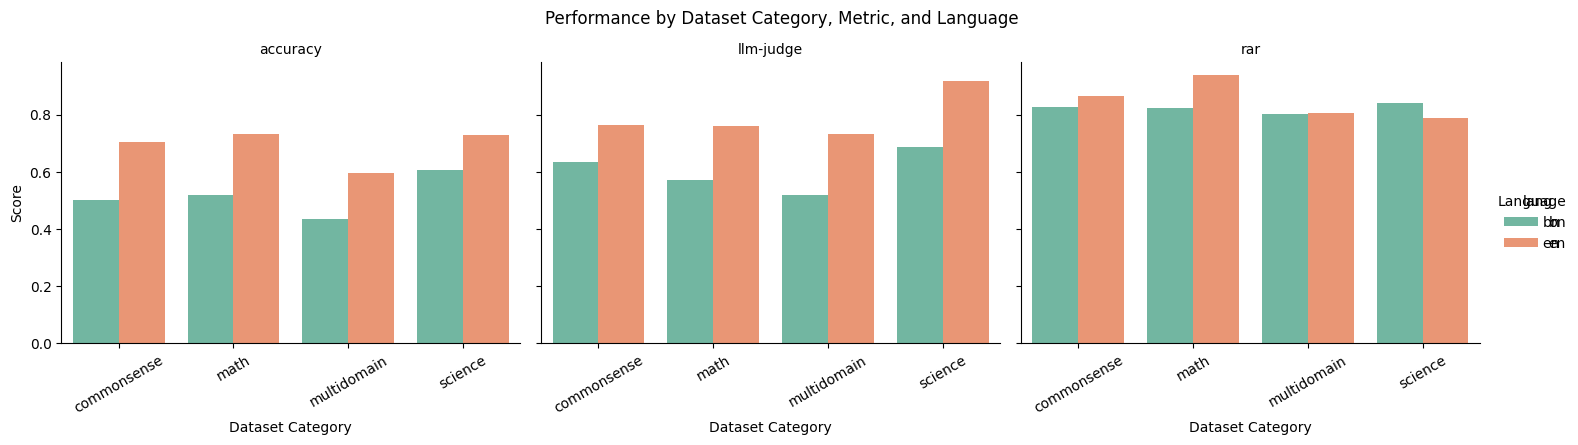

In [ ]:
# Facet barplot: one for each metric
g = sns.catplot(
    data=category_scores,
    x='dataset_category', y='score',
    hue='lang', col='metric_type',
    kind='bar', ci=None, height=4, aspect=1.2,
    palette='Set2'
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels("Dataset Category", "Score")
g.add_legend(title='Language')
g.set_xticklabels(rotation=30)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Performance by Dataset Category, Metric, and Language')
plt.savefig('../fig/category_metric_lang_breakdown.png', dpi=150)
plt.show()
